<a href="https://colab.research.google.com/github/Saputoa21/Machine-Learning/blob/main/Inverted_index_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Simple Inverted Index

In this notebook, we will implement an inverted index structure.   
The inverted index is a data structure that maps each term to the list of documents that contain the term (also called **postings** list). The inverted index is a central data structure in information retrieval systems. It allows us to quickly find and retrieve the documents in which a term appears.

In this notebook, we will test document retrieval with and without indexing, and compare the time taken for each method.


## Data
For the sake of the exercise, you can choose between two corpus:
* The fairy tales corpus: a collection of ~250 fairy tales from the Gutenberg project. The corpus is available in the file `fairytales.csv.zip`, and contains the following columns:
    * `title`: the title of the fairy tale
    * `content`: the content of the fairy tale
    While the csv is zipped, you don't have to unzip it, you can read it directly using pandas' `read_csv` method with the `compression` parameter set to `zip`, like so:
    ```python
    df = pd.read_csv('fairytales.csv.zip', compression='zip')
    ```
* Or the heavier corpus: `stories.zip`, which contains a collection of 230 books, each divided into chapters as a separate text file. To use the corpus, you don't need to unzip it, you can read the files directly from the zip file, using the python's zipfile module. Here's an example:
    ```python
    from zipfile import ZipFile

    with ZipFile('stories.zip', 'r') as zip_ref:
        # looping over the folders using the `namelist` method:
        for file in zip_ref.namelist():
            with zip_ref.open(file) as f:
                text = f.read().decode('utf-8')

                # some naive tokenization - spliting the text by space. You can do better than this ;)
                tokens = text.split()
                for token in tokens:
                    print(token)
    ```
You can also mix and merge both corpus, if you wish.

In [1]:
import pandas as pd
from zipfile import ZipFile

In [3]:
df = pd.read_csv('fairytales.csv.zip', compression='zip')

In [4]:
df.tail()

,title,content,content_length
273,neighbor-underground,Once upon a time there was a peasant who lived...,983
274,lucky-andrew,There was once a rich peasant who had two sons...,2782
275,troll-wife,"Once upon a time, long, long years ago, there ...",1358
276,three-princesses-in-whiteland,"Once upon a time there was a fisherman, who li...",2690
277,kari-woodencoat,ONCE upon a time there was a king whose wife h...,5333


In [5]:
titles_set = set(df['title'])

print(f'Unique feirytales titles: {titles_set}')
print(f'The number of unique fairytale titles: {len(titles_set)}')

Unique feirytales titles: {'help-in-need', 'daniel-o-rourke', 'child-of-mary', 'the-history-of-jack-the-giant-killer', 'the-golden-blackbird', 'the-bunyip', 'stompe-pilt', 'king-kojata', 'the-king-of-the-polar-bears', 'knos', 'prudent-hans', 'story-of-old-man-who-made-withered-trees-to-flower', 'per-gynt', 'torre-jeppe', 'water-lily-gold-spinners', 'the-flying-ogre', 'puppet-show-man', 'leelinau-the-lost-daughter', 'the-roly-poly-pudding', 'the-coming-of-finn', 'the-tale-of-mr-jeremy-fisher', 'what-one-can-invent', 'chronicle-of-pancake', 'the-fairy-nurse', 'osseo-the-son-of-the-evening-star', 'the-war-of-the-wolf-and-the-fox', 'the-mother', 'the-miserly-farmer', 'the-selfish-giant', 'jack-my-hedgehog', 'the-sunchild', 'races', 'the-snow-man', 'self-did-it', 'the-magic-mirror', 'which-was-the-foolishest', 'the-little-spirit-or-boy-man', 'first-born-first-wed', 'anent-giant-who-did-not-have-his-heart-about-him', 'magic-apples', 'sheem-the-forsaken-boy', 'peerifool', 'my-lord-bag-of-rice

In [6]:
fairytale_texts = df['content']

print(fairytale_texts[:10])

0    There was once upon a time a king called Kojat...
1    It generally happens that people's surrounding...
2    There was once a farmer who lived in great com...
3    There was once upon a time a King who had a wi...
4    There was once upon a time a castle in the mid...
5    Once upon a time there lived a King and Queen,...
6    In the reign of the famous King Arthur there l...
7    There was once upon a time a man and his wife ...
8    Once upon a time there was a great lord who ha...
9    In a little village that stood on a wide plain...
Name: content, dtype: object


### Analysing one fairytale

In [7]:
fairytale1 = fairytale_texts[0]

In [10]:
import spacy

nlp = spacy.load("en_core_web_sm")

def tokenise_english_text(text):
  tokenised_text = []
  processed_text = nlp(text)
  for token in processed_text:
    tokenised_text.append(token.text)
  return tokenised_text

In [12]:
tokenised_fairytale1 = tokenise_english_text(fairytale1)

print(tokenised_fairytale1[:100])
print(f'The length of the tokenised text: {len(tokenised_fairytale1)}')

['There', 'was', 'once', 'upon', 'a', 'time', 'a', 'king', 'called', 'Kojata', ',', 'whose', 'beard', 'was', 'so', '\n', 'long', 'that', 'it', 'reached', 'below', 'his', 'knees', '.', 'Three', 'years', 'had', 'passed', 'since', 'his', '\n', 'marriage', ',', 'and', 'he', 'lived', 'very', 'happily', 'with', 'his', 'wife', ',', 'but', 'Heaven', 'granted', '\n', 'him', 'no', 'heir', ',', 'which', 'grieved', 'the', 'King', 'greatly', '.', 'One', 'day', 'he', 'set', 'forth', '\n', 'from', 'his', 'capital', ',', 'in', 'order', 'to', 'make', 'a', 'journey', 'through', 'his', 'kingdom', '.', '\n', 'He', 'travelled', 'for', 'nearly', 'a', 'year', 'through', 'the', 'different', 'parts', 'of', 'his', '\n', 'territory', ',', 'and', 'then', ',', 'having', 'seen', 'all', 'there', 'was']
The length of the tokenised text: 5534


In [13]:
vocab1 = set(tokenised_fairytale1)

print(f'The last ten unique tokens in thee vocabulary: {list(sorted(vocab1)[-10:])}')
print(f'The length of the vocabulary: {len(vocab1)}')

The last ten unique tokens in thee vocabulary: ['wretches', 'wring', 'year', 'years', 'you', 'young', 'youngest', 'your', 'yourself', 'youth']
The length of the vocabulary: 1091


In [14]:
from nltk.probability import FreqDist

def get_frequency(words: list[str], text):
  freq_dist = FreqDist(text)
  for word in words:
    freq = freq_dist[word]
    print(f"{word} = {freq}")

get_frequency(["once", "king", 'journey', "witch"], tokenised_fairytale1)

once = 11
king = 1
journey = 4
witch = 3


In [15]:
import nltk
import string
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def clean_text(tokenised_text):
  clean_text = []
  for token in tokenised_text:
    if token in punctuation or token in stop_words or token == '\n' or  token == '\n\n':
      continue
    else:
      clean_text.append(token)
  return clean_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
clean_fairytale1 = clean_text(tokenised_fairytale1)

print(clean_fairytale1[:100])

['There', 'upon', 'time', 'king', 'called', 'Kojata', 'whose', 'beard', 'long', 'reached', 'knees', 'Three', 'years', 'passed', 'since', 'marriage', 'lived', 'happily', 'wife', 'Heaven', 'granted', 'heir', 'grieved', 'King', 'greatly', 'One', 'day', 'set', 'forth', 'capital', 'order', 'make', 'journey', 'kingdom', 'He', 'travelled', 'nearly', 'year', 'different', 'parts', 'territory', 'seen', 'seen', 'set', 'forth', 'homeward', 'way', 'As', 'day', 'hot', 'sultry', 'commanded', 'servants', 'pitch', 'tents', 'open', 'field', 'await', 'cool', 'evening', 'Suddenly', 'frightful', 'thirst', 'seized', 'King', 'saw', 'water', 'near', 'mounted', 'horse', 'rode', 'neighbourhood', 'looking', 'spring', 'Before', 'long', 'came', 'well', 'filled', 'brim', 'water', 'clear', 'crystal', 'bosom', 'golden', 'jug', 'floating', 'King', 'Kojata', 'tried', 'seize', 'vessel', 'though', 'endeavoured', 'grasp', 'right', 'hand', 'left', 'wretched', 'thing']


In [17]:
from nltk.probability import FreqDist

def get_most_frequent_filtered(n: int, text):
  freq_dist = FreqDist(text)
  most_common_freq_dist = freq_dist.most_common()

  punctuation_list = list(string.punctuation)
  stopwords_list = stopwords.words('english')

  filtered_freq_dist = []
  for word in most_common_freq_dist:
    if word[0].lower() not in stopwords_list and word[0] not in punctuation_list and word[0] != '\n' and word[0] != '\n\n':
      filtered_freq_dist.append(word)
    continue
  return filtered_freq_dist[:n]

In [18]:
get_most_frequent_filtered(10, tokenised_fairytale1)

[('Prince', 60),
 ('Milan', 40),
 ('Hyacinthia', 30),
 ('King', 24),
 ('little', 22),
 ("n't", 20),
 ('beautiful', 20),
 ('said', 19),
 ('time', 18),
 ("'s", 18)]

### Analysing all fairytales

In [19]:
clean_fairytale_texts = []

for fairytale_text in fairytale_texts:
  tokenised_fairytale = tokenise_english_text(fairytale_text)
  clean_fairytale_text = clean_text(tokenised_fairytale)
  clean_fairytale_texts.append(clean_fairytale_text)

In [20]:
print((clean_fairytale_texts)[:2])
print(len(clean_fairytale_texts))

[['There', 'upon', 'time', 'king', 'called', 'Kojata', 'whose', 'beard', 'long', 'reached', 'knees', 'Three', 'years', 'passed', 'since', 'marriage', 'lived', 'happily', 'wife', 'Heaven', 'granted', 'heir', 'grieved', 'King', 'greatly', 'One', 'day', 'set', 'forth', 'capital', 'order', 'make', 'journey', 'kingdom', 'He', 'travelled', 'nearly', 'year', 'different', 'parts', 'territory', 'seen', 'seen', 'set', 'forth', 'homeward', 'way', 'As', 'day', 'hot', 'sultry', 'commanded', 'servants', 'pitch', 'tents', 'open', 'field', 'await', 'cool', 'evening', 'Suddenly', 'frightful', 'thirst', 'seized', 'King', 'saw', 'water', 'near', 'mounted', 'horse', 'rode', 'neighbourhood', 'looking', 'spring', 'Before', 'long', 'came', 'well', 'filled', 'brim', 'water', 'clear', 'crystal', 'bosom', 'golden', 'jug', 'floating', 'King', 'Kojata', 'tried', 'seize', 'vessel', 'though', 'endeavoured', 'grasp', 'right', 'hand', 'left', 'wretched', 'thing', 'always', 'eluded', 'efforts', 'refused', 'let', 'caug

In [35]:
# 5 Most grequent words per fairytale
most_freq_word_dict = {}
i = 0

for clean_fairytale_text in clean_fairytale_texts:
  most_freq_word_dict[i] = get_most_frequent_filtered(5, clean_fairytale_text)
  i = i + 1

In [30]:
print(most_freq_word_dict)

{0: [('Prince', 60), ('Milan', 40), ('Hyacinthia', 30), ('King', 24), ('little', 22)], 1: [('Fairy', 19), ('Sylvia', 17), ('gift', 11), ('time', 10), ('one', 8)], 2: [('Jack', 36), ('King', 24), ('Hedgehog', 20), ('cock', 15), ('said', 14)], 3: [('King', 36), ('said', 19), ('cook', 18), ('one', 17), ('soup', 17)], 4: [('castle', 9), ('Jorinde', 9), ('Joringel', 9), ('went', 9), ('old', 8)], 5: [('Princess', 41), ('Prince', 31), ('Celandine', 31), ('old', 25), ('Fairy', 24)], 6: [('Jack', 37), ('giant', 29), ("'s", 16), ('went', 10), ('castle', 9)], 7: [('said', 22), ('cat', 19), ('dog', 16), ('Simon', 12), ('Susan', 12)], 8: [('Golden', 19), ('little', 19), ('hare', 16), ('Blackbird', 14), ('Porcelain', 14)], 9: [('man', 17), ('husband', 12), ('wife', 11), ('see', 9), ('quite', 7)], 10: [('Jegu', 22), ('Barbaik', 19), ('would', 16), ('brownie', 13), ('little', 11)], 11: [('Letiko', 29), ('Sunball', 15), ('came', 12), ('home', 12), ('said', 11)], 12: [('water', 8), ('Bunyip', 7), ('men'

In [51]:
# 10 Most frequent words across all fairtales

merged_fairytales = [token for sublist in clean_fairytale_texts for token in sublist]

print(merged_fairytales)
print(type(merged_fairytales))

['There', 'upon', 'time', 'king', 'called', 'Kojata', 'whose', 'beard', 'long', 'reached', 'knees', 'Three', 'years', 'passed', 'since', 'marriage', 'lived', 'happily', 'wife', 'Heaven', 'granted', 'heir', 'grieved', 'King', 'greatly', 'One', 'day', 'set', 'forth', 'capital', 'order', 'make', 'journey', 'kingdom', 'He', 'travelled', 'nearly', 'year', 'different', 'parts', 'territory', 'seen', 'seen', 'set', 'forth', 'homeward', 'way', 'As', 'day', 'hot', 'sultry', 'commanded', 'servants', 'pitch', 'tents', 'open', 'field', 'await', 'cool', 'evening', 'Suddenly', 'frightful', 'thirst', 'seized', 'King', 'saw', 'water', 'near', 'mounted', 'horse', 'rode', 'neighbourhood', 'looking', 'spring', 'Before', 'long', 'came', 'well', 'filled', 'brim', 'water', 'clear', 'crystal', 'bosom', 'golden', 'jug', 'floating', 'King', 'Kojata', 'tried', 'seize', 'vessel', 'though', 'endeavoured', 'grasp', 'right', 'hand', 'left', 'wretched', 'thing', 'always', 'eluded', 'efforts', 'refused', 'let', 'caugh

In [52]:
ten_most_freq_words = get_most_frequent_filtered(10, merged_fairytales)

print(ten_most_freq_words)

[('said', 3851), ("'s", 2731), ('one', 2206), ('\r', 2083), ('would', 1807), ('could', 1745), ('came', 1715), ('old', 1601), ('little', 1599), ('man', 1571)]


### Visualisation

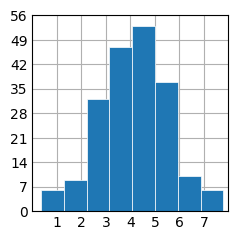

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data
np.random.seed(1)
x = 4 + np.random.normal(0, 1.5, 200)

# plot:
fig, ax = plt.subplots()

ax.hist(x, bins=8, linewidth=0.5, edgecolor="white")

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 56), yticks=np.linspace(0, 56, 9))

plt.show()

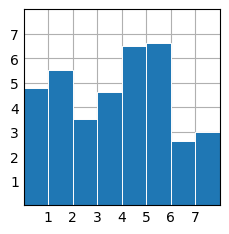

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')


df()
# make data:
x = 0.5 + np.arange(8)
y = [4.8, 5.5, 3.5, 4.6, 6.5, 6.6, 2.6, 3.0]

# plot
fig, ax = plt.subplots()

ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

## Linear Search

Let's start with a simple linear search.
Given a query string, the function `linear_search` should return a list of documents (or document ids) that contain it.

Implement the function `linear_search` below, and measure its execution time for some example queries. Store these results and measure the mean the standard deviation of these times.

In [ ]:
# Here are some ideas for queries. You can also come up with your own, or mix and match terms from different queries.
queries = [
    "warrior",
    "hunter",
    "lodge",
    "father",
    "king",
    "forest",
    "magic",
    "sword",
    "queen",
    "princess",
    "castle",
    "home",
    "dream",
    "fish",
    "sleep",
    "life",
    "ship",
    "luck",
    "wisdom",
    "hand",
    "pig",
    "child",
    "friend",
    "love",
    "woman",
    "pancake",
    "money",
    "bank",
    "arrow",
    "slave",
    "music",
    "work",
    "respect"  # from here I added some new keywords
    "witch",
    "kingsom",
    "knight",
    "dragon",
    "evil",
    "good",
    "esolution",
    "protagonist",
    "goblin",
    "tiara",
    "curse",
    "carriage",
    "wicked",
    "character"
    "ogre",
    "adventure",
    "hero",
    "weak",
    "tower",
    "enemy",
    "fairy",
    "antagonist",
    "step-mother",
    "enchantment",
    "myth",
    "crown",
    "fairy godmother",
    "maiden",
    "story",
    "villain",
    "horse",
    "dwarf",
    "beautiful",
    "frog",
    "elf",
    "beast",
    "giant",
    "once upon a time...",
    "happily ever after...",
    "folktale",
    "gown"
]

In [ ]:
### YOUR CODE HERE ###
def linear_search(documents, query: str):
    pass

Q: How long did it take your ur linear search to find the documents for each query?
Q: What was the mean and standard deviation of these times?


### Measuring execution times:

To measure the execution time of a function, you can use the `time` module in Python. Here's an example of how to use it:
```python
import time
start_time = time.time()

# Your code here

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
```

---

But you can make it even smarter, with reusable code, by [using a decorator](https://www.geeksforgeeks.org/timing-functions-with-decorators-python/):
```python
from time import time

def timer_func(func):
    """This function shows the execution time of the function object passed"""
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

@timer_func
def long_time(n):
    for i in range(n):
        for j in range(100000):
            i*j

long_time(5)
# Output: Function 'long_time' executed in 0.0468s
```

## Inverted Index

Now let's implement an inverted index. This will allow us to retrieve documents much faster than linear search.
Implement a simple inverted index. You can use the following class as a starting point, or create your own.

We will start simple: Just store the document IDs in a list for each token. If you want to be more advanced, you can store the document IDs as tuples, or a more complex object that stores the document ID and the position of the token in the document.  
**Remember**: you are the queens, kings and gods in this realm. You can do whatever you want.


In [ ]:
### YOUR CODE HERE ###

class InvertedIndex:
    def __init__(self):
        self.index = {}
        self.documents = []

    def add_document(self, doc_id, tokens):
        self.documents.append(doc_id)
        for token in tokens:
            if token not in self.index:
                self.index[token] = []
            self.index[token].append(doc_id)

    def get_postings(self, token):
        return self.index.get(token, [])

    def get_documents(self):
        return self.documents

In [ ]:
### Run the retrieval using inverted index on the same queries as before

Experiment again with the previous queries on the invertedt index, and time the results.  
How long did it take to retrieve the documents for these same queries? What was the mean and standard deviation of these execution times?